<a href="https://colab.research.google.com/github/Yechaann/image/blob/main/miniProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **기계학습(Machine Learning)**

건국대학교, 전기전자공학부, 유승수

참고서적: 강영민, 박동규, 김성수, 으뜸 머신러닝, 생능출판사, 대한민국, 파주, 2021년.

저작권: 본 주피터 노트북의 코드는 위 참고서적에서 제공하는 코드를 바탕으로 설명에 맞도록 일부 수정 및 보완하였습니다. 참고서적에서 제공하는 코드 자체는 출판사, 저서, 저자 표기와 함께 배포가 가능하지만 수정 및 보완된 본 코드에 대한 배포는 허용하지 않습니다. 


---


---
## **미니 프로젝트 A1 : 잡음제거: k-NN의 활용**


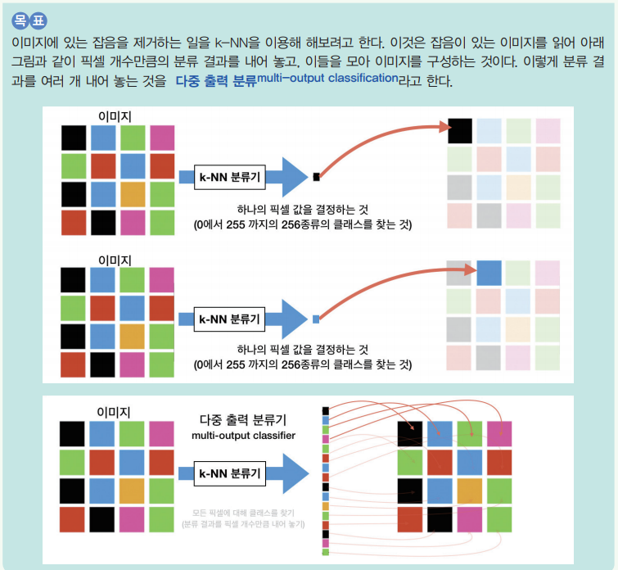

### **1. 미리 준비할 것**
* 이미지를 다루기 위해 사이킷런에서 제공하는 [사이킷 이미지 scikit-image](https://scikit-image.org)를 사용한다.

* 이 프로젝트에서는 이미지를 읽기 위해 imread( ) 함수를 사용한다.
* 이 프로젝트에서는 이미지의 크기를 변경하기 위해 resize( ) 함수를 사용한다.


In [52]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread             # imread( ) 함수 importing
from skimage.transform import resize      # resize( ) 함수 importing

### **2. 이미지 읽어 들이기**

* img01.jpg부터 img40.jpg까지 40장의 이미지를 사전에 이미지를 저장해놓은 URL로부터 읽어 들이자.
* 읽어 들인 이미지는 이미지 처리를 할 수 있도록 $24 \times 24$ 크기로 변경하자.

In [53]:
url = 'https://raw.githubusercontent.com/Yechaann/image/main/proj1/'

imgR, imgC, channel = 24, 24, 3
images = []

for i in range(40):
    file = url + 'img{0:02d}.jpg'.format(i+1)    # 이미지 파일 이름을 만든다
    img = imread(file)                           # 이미지를 읽는다
    img = resize(img, (imgR,imgC, channel))      # 이미지의 크기를 변경한다. channel=3은 RGB 채널을 뜻한다.
    images.append(img)                           # images 리스트에 담는다

<Figure size 432x288 with 0 Axes>

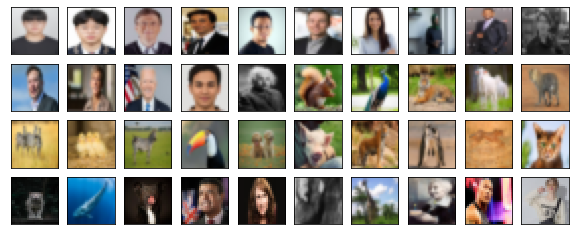

In [54]:
def plot_images(nRow, nCol, img):
    fig = plt.figure()
    fig, ax = plt.subplots(nRow, nCol, figsize = (nCol,nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1: axis = ax[j]
            else:         axis = ax[i, j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol+j])
plot_images(4, 10, images)

### **3. 훈련용 데이터와 검증용 데이터 분리**
* 기계 학습은 데이터를 통해 훈련한 뒤에 훈련에 사용한 적이 없는 새로운 데이터를 모델에 적용할 수 있다. 이를 일반화라고 부른다.
* 훈련 단계에서 일반화 능력을 검증하기 위해 보유한 데이터 가운데 일부는 훈련용 데이터, 일부는 검증용 데이터로 분류해야 한다.
* 보유한 40장의 데이터 가운데 30장은 훈련용 데이터로 활용하고, 10장은 검증용 데이터로 활용하자.

<Figure size 432x288 with 0 Axes>

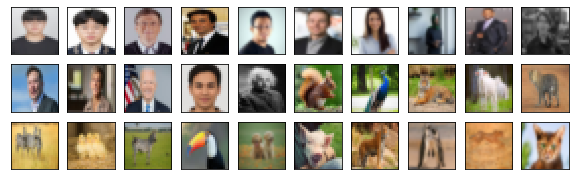

<Figure size 432x288 with 0 Axes>

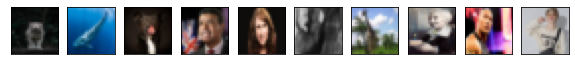

In [55]:
X = np.array(images[:30])
X_test = np.array(images[30:])
plot_images(3, 10, X)
plot_images(1, 10, X_test)

### **4. 입력 데이터 준비**
* 제공된 데이터는 잡음이 없는 깨끗한 이미지로서 정답 레이블로 사용될 데이터이다.
* 잡음이 섞인 추가 입력에 대해 훈련된 모델을 사용하기 위해 임의로 잡음이 섞인 이미지를 만들고 이를 사용해 훈련을 해야 한다.
* 정규 분포를 갖는 잡음을 생성하고, 기존 이미지에 이를 더해보자.

In [56]:
# 잡음을 생성하자
X_noisy = X + np.random.randn(len(X), imgR, imgC, channel)*0.1
X_noisy = np.clip(X_noisy, 0, 1) # np.clip(arr, min, max): 입력된 배열 arr의 값 가운데 min 보다 작은 값은 min으로 max 보다 큰 값은 max 값으로 clipping
X_test_noisy =  X_test+ np.random.randn(len(X_test),imgR,imgC,channel)*0.1
X_test_noisy = np.clip(X_test_noisy, 0, 1)

<Figure size 432x288 with 0 Axes>

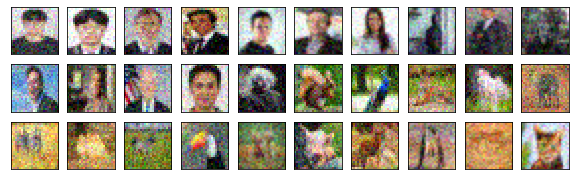

<Figure size 432x288 with 0 Axes>

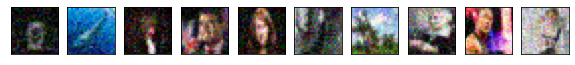

In [57]:
# 잡음이 추가된 이미지들을 그려보자
plot_images(3, 10, X_noisy)
plot_images(1, 10, X_test_noisy)

### **5. 분류기 입출력 데이터 형식에 맞추어 훈련하기**
* 사이킷런의 $k$-NN 분류기는 1차원 벡터 데이터만 취급한다. 따라서 제공된 이미지를 1차원 벡터로 변환해야 한다. 

In [58]:
X_noisy_flat = X_noisy.reshape(-1, imgR*imgC*channel) # 인자 -1은 나머지 축에 지정된 값에 맞춰 자동 설정하라는 뜻
X_flat = np.array(X.reshape(-1, imgR*imgC*channel) * 255, dtype=np.uint)

In [59]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_noisy_flat, X_flat)

KNeighborsClassifier()

<Figure size 432x288 with 0 Axes>

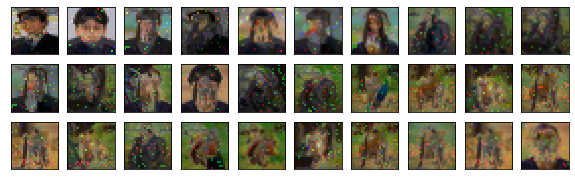

In [60]:
denoised_result = knn.predict(X_noisy_flat)
denoised_result = denoised_result.reshape(-1, imgR, imgC, channel)
plot_images(3, 10, denoised_result)

### 6. 데이터를 증강하여 훈련 효과 높이기

In [61]:
n_augmentation = 100
X_noisy_aug = X + np.random.rand(len(X), imgR, imgC, channel) * 0.2
y_label = np.array(X * 255, dtype = np.uint)
y = y_label

print(X_noisy.shape)
for i in range(n_augmentation):
    noisy_data = X + np.random.randn(len(X), imgR, imgC, channel) * 0.2
    X_noisy_aug = np.append(X_noisy_aug, noisy_data, axis=0)
    y = np.append(y, y_label, axis = 0)

X_noisy_aug = np.clip(X_noisy_aug, 0, 1)
X_noisy_aug.shape, y.shape

(30, 24, 24, 3)


((3030, 24, 24, 3), (3030, 24, 24, 3))

<Figure size 432x288 with 0 Axes>

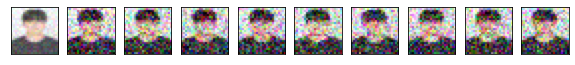

In [62]:
# 슬라이싱을 이용해서 데이터의 일부를 그려보자
plot_images(1, 10, X_noisy_aug[0:300:30])

In [63]:
# 늘어난 데이터로 훈련을 시켜보자
X_noisy_aug_flat = X_noisy_aug.reshape(-1, imgR*imgC*channel)
y_flat = y.reshape(-1, imgR*imgC*channel)

knn.fit(X_noisy_aug_flat, y_flat)

KNeighborsClassifier()

<Figure size 432x288 with 0 Axes>

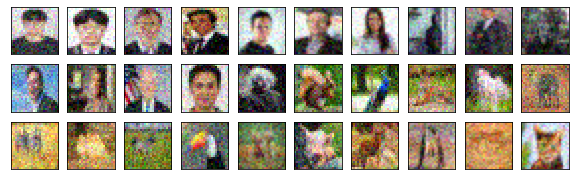

<Figure size 432x288 with 0 Axes>

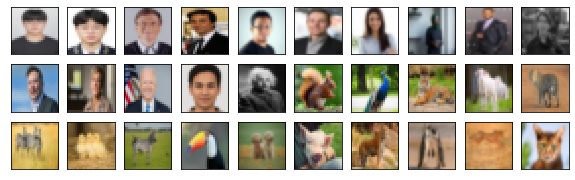

In [64]:
# 잡음이 포함된 X_noisy_flat 이미지를 kNN 알고리즘을 이용하여 잡음을 제거
denoised_result = knn.predict(X_noisy_flat)
denoised_result = denoised_result.reshape(-1, imgR, imgC, channel)

plot_images(3, 10, X_noisy)
plot_images(3, 10, denoised_result)

### **7. 검증 데이터로 일반화 능력을 살펴보자**

<Figure size 432x288 with 0 Axes>

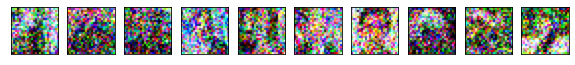

<Figure size 432x288 with 0 Axes>

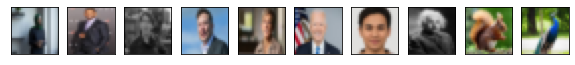

In [65]:
rndidx = np.random.randint(0, 20)
data = X[rndidx:rndidx+10] + np.random.randn(10, imgR, imgC, channel)*0.4
data = np.clip(data, 0, 1)
data_flat = data.reshape(-1, imgR*imgC*channel)

denoised = knn.predict(data_flat)
denoised = denoised.reshape(-1, imgR, imgC, channel)
denoised = np.clip(denoised, 0, 255)

plot_images(1, 10, data)
plot_images(1, 10, denoised)

<Figure size 432x288 with 0 Axes>

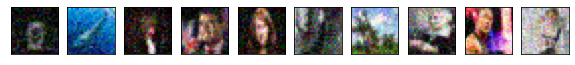

<Figure size 432x288 with 0 Axes>

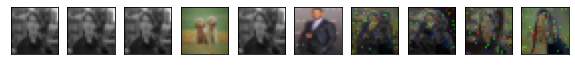

In [66]:
denoised = knn.predict(X_test_noisy.reshape(-1, imgR*imgC*channel))
denoised = denoised.reshape(-1, imgR, imgC, channel)

plot_images(1, 10, X_test_noisy)
plot_images(1, 10, denoised)

### **8. 데이터 증강으로 일반화 능력을 높여보자.**

In [67]:
### 이미지 데이터를 증강시키기 ####
from keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(
    rotation_range=360,
    zoom_range=0.1,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

In [68]:
y_aug = X.reshape(-1, imgR, imgC, channel)
it = image_generator.flow(y_aug)
nData = y_aug.shape[0]

In [69]:
X_aug = y_aug + np.random.randn(nData, imgR, imgC, channel)*0.1

In [70]:
n_augmentation = 500
for _ in range(n_augmentation):
    new_y = it.next()
    new_X = new_y + np.random.randn(nData, imgR, imgC, channel)*0.1
    y_aug = np.append(y_aug, new_y)    
    X_aug = np.append(X_aug, new_X)

y_aug = np.array(y_aug * 255, dtype = np.uint)
y_aug = y_aug.reshape(-1, imgR, imgC, channel)
X_aug = X_aug.reshape(-1, imgR, imgC, channel)

<Figure size 432x288 with 0 Axes>

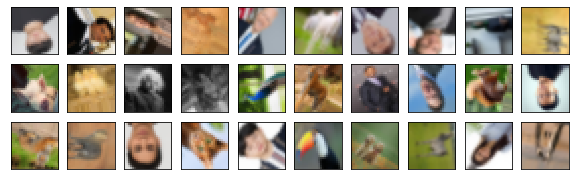

In [71]:
y_aug = np.clip(y_aug, 0,255)
X_aug = np.clip(X_aug, 0, 1)
plot_images(3, 10, y_aug[30:])

### **9. 새로 학습하고 검증용 데이터 적용하기**

In [72]:
X_aug_flat = X_aug.reshape(-1, imgR*imgC*channel)
y_aug_flat = y_aug.reshape(-1, imgR*imgC*channel)
knn.fit(X_aug_flat, y_aug_flat)

KNeighborsClassifier()

<Figure size 432x288 with 0 Axes>

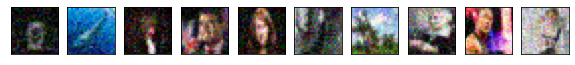

<Figure size 432x288 with 0 Axes>

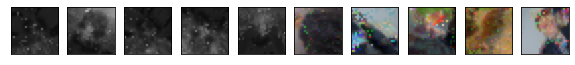

In [73]:
denoised = knn.predict(X_test_noisy.reshape(-1, imgR*imgC*channel))
denoised = denoised.reshape(-1, imgR, imgC, channel)
plot_images(1, 10, X_test_noisy)
plot_images(1, 10, denoised)

<Figure size 432x288 with 0 Axes>

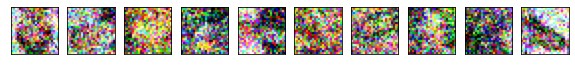

<Figure size 432x288 with 0 Axes>

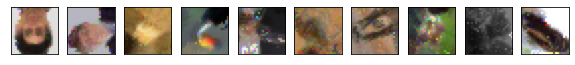

In [74]:
# 보다 더 강한 잡음을 추가하도록 하자
images = it.next()
testX = images + np.random.randn(nData, imgR, imgC, channel)*0.4
testX = np.clip(testX, 0, 1)
denoised = knn.predict(testX.reshape(-1, imgR*imgC*channel))
denoised = denoised.reshape(-1, imgR, imgC, channel)

plot_images(1, 10, testX)
plot_images(1, 10, denoised)

---
## **미니 프로젝트 B1 얼굴 찾기: SVM으로 분류하기**

* SVM을 이용하여 주어진 이미지가 사람의 얼굴인지 아닌지 구분하는 프로그램을 만들어보자.

### **1. 데이터 확인**

[여기](https://github.com/dknife/ML/raw/main/data/Proj2)에 접속해 faces와 animals라는 두 개의 서브 폴더와 서브 폴더 내 이미지를 확인하자. 

### **2. 미리 준비할 것**

* 이미지를 다루기 위해 사이킷런에서 제공하는 **[사이킷 이미지](https://scikit-image.org)** scikit-image를 사용한다.

* 주요 함수 소개
 - imread( ): 이미지 읽기
 - resize( ): 이미지 크기 변경
 - hog( ): 이미지를 영역별로 분할하고, 영역내 픽셀 기울기 gradient의 히스토그램 histogram을 구하는 함수

In [75]:
# 주요 패키지 import
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog

### **3. 얼굴 이미지 읽고 확인해보기**

* 사람 얼굴 이미지를 정 positive 그룹으로, 다른 이미지들을 부 negative 그룹으로 모델에 제공해야 한다.
* 읽어 들인 이미지의 크기가 제각각이므로 모든 이미지의 크기를 $64 \times 64$ 크기로 조정한다. 

<Figure size 432x288 with 0 Axes>

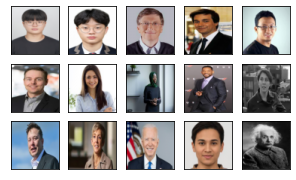

In [76]:
url = 'https://raw.githubusercontent.com/Yechaann/image/main/proj2/faces/'

face_images = []

for i in range(15):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (64,64))
    face_images.append(img)

# 3행 5열로 이미지 그리기
def plot_images(nRow, nCol, img):
    fig = plt.figure()
    fig, ax = plt.subplots(nRow, nCol, figsize = (nCol,nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1: axis = ax[j]
            else:         axis = ax[i, j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol+j])


plot_images(3,5, face_images)

### **4. 얼굴 이미지의 특징 데이터 구하기**

* 얼굴 이미지의 대표적 특징 가운데 하나인 기울기 히스토그램을 사용해보자.

<Figure size 432x288 with 0 Axes>

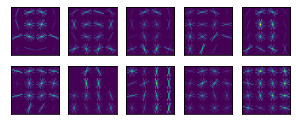

<Figure size 432x288 with 0 Axes>

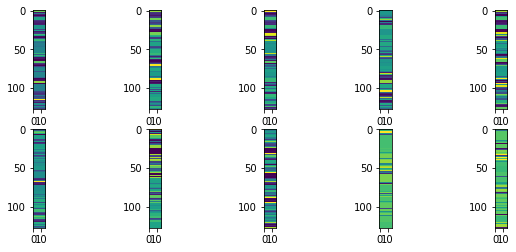

In [77]:
face_hogs = []
face_features = []
for i in range(10):
    hog_desc, hog_image = hog(face_images[i], orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=True)
    face_hogs.append(hog_image)
    face_features.append(hog_desc)

plot_images(2, 5, face_hogs)

fig = plt.figure()
fig, ax = plt.subplots(2,5, figsize = (10,4))
for i in range(2):
 for j in range(5):
   ax[i, j].imshow(resize(face_features[i*5+j], (128,16)), interpolation='nearest')


### **5. 사람 얼굴이 아닌 이미지의 특징 벡터 준비**

<Figure size 432x288 with 0 Axes>

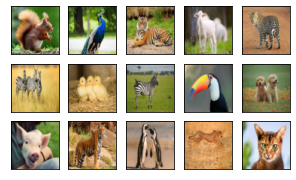

In [78]:
# 
url = 'https://raw.githubusercontent.com/Yechaann/image/main/proj2/animals/'
animal_images = []

for i in range(15):
  file = url + 'img{0:02d}.jpg'.format(i+1)
  img = imread(file)
  img = resize(img, (64, 64))
  animal_images.append(img)

plot_images(3, 5, animal_images)

<Figure size 432x288 with 0 Axes>

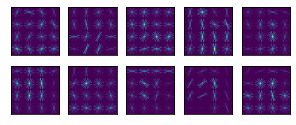

<Figure size 432x288 with 0 Axes>

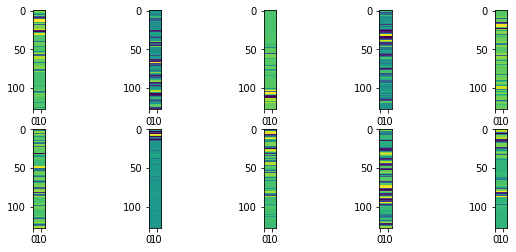

In [79]:
animal_hogs = []
animal_features = []
for i in range(10):
    hog_desc, hog_image = hog(animal_images[i], orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=True)
    animal_hogs.append(hog_image)
    animal_features.append(hog_desc)

plot_images(2, 5, animal_hogs)

fig = plt.figure()
fig, ax = plt.subplots(2,5, figsize = (10,4))
for i in range(2):
 for j in range(5):
   ax[i, j].imshow(resize(animal_features[i*5+j], (128,16)), interpolation='nearest')


### **6. 학습을 위한 데이터 만들어 학습하기**

In [80]:
X, y = [], []

for feature in face_features:
  X.append(feature)
  y.append(1)
for feature in animal_features:
  X.append(feature)
  y.append(0)
print(y)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [81]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

polynomial_svm_clf = Pipeline([
                               ("scalar", StandardScaler()),
                               ("svm_clf", SVC(C=1, kernel = 'poly', degree=5, coef0=10.0))
                               ])
polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('scalar', StandardScaler()),
                ('svm_clf', SVC(C=1, coef0=10.0, degree=5, kernel='poly'))])

In [82]:
yhat = polynomial_svm_clf.predict(X)
print(yhat)

[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]


### **7. 새로운 데이터에 적용해보기**


<Figure size 432x288 with 0 Axes>

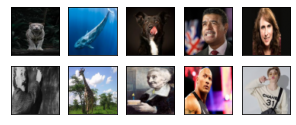

In [85]:
url = 'https://raw.githubusercontent.com/Yechaann/image/main/proj2/test/'

test_images = []

for i in range(10):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (64,64))
    test_images.append(img)

plot_images(2, 5, test_images)

<Figure size 432x288 with 0 Axes>

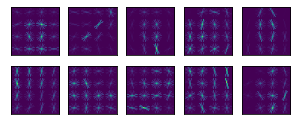

<Figure size 432x288 with 0 Axes>

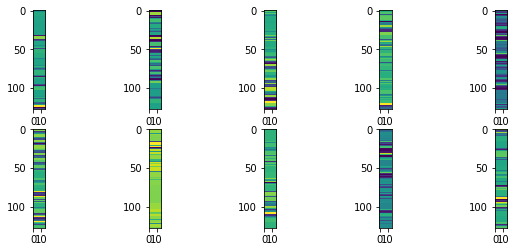

In [86]:
test_hogs = []
test_features = []
for i in range(10):
    hog_desc, hog_image = hog(test_images[i], orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=True)
    test_hogs.append(hog_image)
    test_features.append(hog_desc)

plot_images(2, 5, test_hogs)

fig = plt.figure()
fig, ax = plt.subplots(2,5, figsize = (10,4))
for i in range(2):
 for j in range(5):
   ax[i, j].imshow(resize(test_features[i*5+j], (128,16)), interpolation='nearest')


In [87]:
test_result = polynomial_svm_clf.predict(test_features)
print(test_result)

[0 0 0 0 1 0 0 0 1 0]


<Figure size 432x288 with 0 Axes>

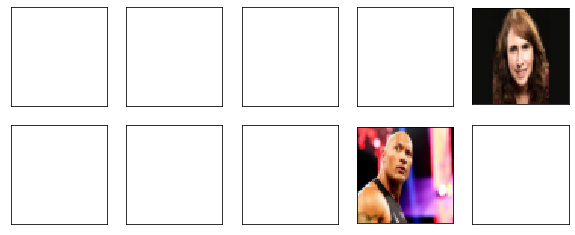

In [88]:
fig = plt.figure()
fig, ax = plt.subplots(2,5, figsize = (10,4))
for i in range(2):
    for j in range(5):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        if test_result[i*5+j] == 1:
            ax[i, j].imshow(test_images[i*5+j],interpolation='nearest')